In [86]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
# from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import nltk
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
lemmatizer = WordNetLemmatizer()
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics

In [3]:
df_train = pd.read_csv("drugsComTrain_raw.csv")

In [4]:
df_test = pd.read_csv("drugsComTest_raw.csv")

In [5]:
df_train.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [6]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [7]:
df_train['review'].head(10)

0    "It has no side effect, I take it in combinati...
1    "My son is halfway through his fourth week of ...
2    "I used to take another oral contraceptive, wh...
3    "This is my first time using any form of birth...
4    "Suboxone has completely turned my life around...
5    "2nd day on 5mg started to work with rock hard...
6    "He pulled out, but he cummed a bit in me. I t...
7    "Abilify changed my life. There is hope. I was...
8    " I Ve had  nothing but problems with the Kepp...
9    "I had been on the pill for many years. When m...
Name: review, dtype: object

In [8]:
df_train['sentiment'] = df_train['rating'].apply(lambda x: 1 if x>5 else 0)

In [9]:
# nltk.download()

In [10]:
from tqdm import tqdm

def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['review']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
            
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)


In [11]:
df_train['tokens'] = clean_sentences(df_train)
df_test['tokens'] = clean_sentences(df_test)

100%|██████████████████████████████████████████████████████████████████████████| 53766/53766 [00:40<00:00, 1320.50it/s]


In [60]:
from nltk.corpus import stopwords
stopword = stopwords.words('english')
negated_words = ['don',"don't",'ain','aren',"aren't",'couldn',"couldn't",
                 'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",
                'against','no','not','no','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',
                 "shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
stop = []
for w in stopword:
    if w not in negated_words:
        stop.append(w)

In [61]:
def clean(sen):
    return [word for word in sen if word not in stop]

In [62]:
df_train['cleaned']= df_train['tokens'].apply(clean)
df_test['cleaned'] = df_test['tokens'].apply(clean)

In [16]:
def vocab(df):
    voc = []
    for x in df['cleaned']:
        for i in range(len(x)):
            voc.append((x[i]))
    return voc

In [17]:
pos = []
neg = []
pos = vocab(df_train.loc[df_train.sentiment == 1])
neg = vocab(df_train.loc[df_train.sentiment == 0])

In [18]:
x = df_train['cleaned'].head(1)
p = x.index
df_train.iloc[p,0]

0    206461
Name: uniqueID, dtype: int64

In [19]:
freq = nltk.FreqDist(pos)
freq.keys()

dict_keys(['ha', 'side', 'effect', 'take', 'combination', 'bystolic', 'mg', 'fish', 'oil', 'son', 'halfway', 'fourth', 'week', 'intuniv', 'became', 'concerned', 'began', 'last', 'started', 'taking', 'highest', 'dose', 'two', 'day', 'could', 'hardly', 'get', 'bed', 'wa', 'cranky', 'slept', 'nearly', 'hour', 'drive', 'home', 'school', 'vacation', 'unusual', 'called', 'doctor', 'monday', 'morning', 'said', 'stick', 'see', 'getting', 'problem', 'free', 'much', 'agreeable', 'ever', 'le', 'emotional', 'good', 'thing', 'remembering', 'overall', 'behavior', 'better', 'tried', 'many', 'different', 'medication', 'far', 'effective', 'first', 'time', 'using', 'form', 'birth', 'control', 'glad', 'went', 'patch', 'month', 'decreased', 'libido', 'subsided', 'downside', 'made', 'period', 'longer', 'exact', 'used', 'max', 'also', 'cramp', 'intense', 'never', 'happy', 'suboxone', 'completely', 'turned', 'life', 'around', 'feel', 'healthier', 'excelling', 'job', 'always', 'money', 'pocket', 'saving', 'ac

In [20]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,tokens,cleaned
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1,"[it, ha, no, side, effect, i, take, it, in, co...","[ha, side, effect, take, combination, bystolic..."
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1,"[my, son, is, halfway, through, his, fourth, w...","[son, halfway, fourth, week, intuniv, became, ..."
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0,"[i, used, to, take, another, oral, contracepti...","[used, take, another, oral, contraceptive, pil..."
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1,"[this, is, my, first, time, using, any, form, ...","[first, time, using, form, birth, control, gla..."
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1,"[suboxone, ha, completely, turned, my, life, a...","[suboxone, ha, completely, turned, life, aroun..."


In [21]:
df_ = pd.concat([df_train, df_test], axis=0, sort=True)

In [22]:
df_['review'] = df_['review'].astype(str).fillna(' ')
# Lower case comment
df_['review'] = df_['review'].str.lower()
# Add num words of comment as feature
df_['num_words'] = df_['review'].apply(lambda s: len(s.split()))
# Add num words unique of comment as feature
df_['num_unique_words'] = df_['review'].apply(lambda s: len(set(w for w in s.split())))
# Add num words unique per num words of comment as feature
df_['words_vs_unique'] = df_['num_unique_words'] / df_['num_words'] * 100

In [23]:
df_.head()

,cleaned,condition,date,drugName,rating,review,sentiment,tokens,uniqueID,usefulCount,num_words,num_unique_words,words_vs_unique
0,"[ha, side, effect, take, combination, bystolic...",Left Ventricular Dysfunction,20-May-12,Valsartan,9,"""it has no side effect, i take it in combinati...",1.0,"[it, ha, no, side, effect, i, take, it, in, co...",206461,27,17,17,100.000000
1,"[son, halfway, fourth, week, intuniv, became, ...",ADHD,27-Apr-10,Guanfacine,8,"""my son is halfway through his fourth week of ...",1.0,"[my, son, is, halfway, through, his, fourth, w...",95260,192,141,106,75.177305
2,"[used, take, another, oral, contraceptive, pil...",Birth Control,14-Dec-09,Lybrel,5,"""i used to take another oral contraceptive, wh...",0.0,"[i, used, to, take, another, oral, contracepti...",92703,17,134,95,70.895522
3,"[first, time, using, form, birth, control, gla...",Birth Control,3-Nov-15,Ortho Evra,8,"""this is my first time using any form of birth...",1.0,"[this, is, my, first, time, using, any, form, ...",138000,10,89,57,64.044944
4,"[suboxone, ha, completely, turned, life, aroun...",Opiate Dependence,27-Nov-16,Buprenorphine / naloxone,9,"""suboxone has completely turned my life around...",1.0,"[suboxone, ha, completely, turned, my, life, a...",35696,37,124,86,69.354839


In [24]:
# recover train set test set as before
train_df = df_[~df_['sentiment'].isnull()]
test_df = df_[df_['sentiment'].isnull()]
y_train = train_df['sentiment'].values

In [25]:
EXCLUED_COLS = ['id', 'comment', 'label']
static_cols = [c for c in train_df.columns if not c in EXCLUED_COLS]
print(static_cols)
X_train_static = train_df[static_cols].values
X_test_static = test_df[static_cols].values
print(X_train_static.shape, X_test_static.shape)

['cleaned', 'condition', 'date', 'drugName', 'rating', 'review', 'sentiment', 'tokens', 'uniqueID', 'usefulCount', 'num_words', 'num_unique_words', 'words_vs_unique']
(161297, 13) (53766, 13)


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack, csr_matrix, vstack
import pickle as pickle

In [27]:
tfidf = TfidfVectorizer(
    min_df = 5, 
    max_df = 0.8, 
    max_features=10000,
    sublinear_tf=True
)

In [30]:
train_comments = train_df['review'].values
test_comments = test_df['review'].values
X_train_tfidf = tfidf.fit_transform(train_comments)
X_test_tfidf = tfidf.transform(test_comments)

In [32]:
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train_tfidf, y_train, test_size=0.1)

In [33]:
X_train_split

<145167x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 8276581 stored elements in Compressed Sparse Row format>

In [34]:
param = {'num_leaves':100, 'num_trees':300, 'objective':'binary', "max_bin":255, "learning_rate":0.1, "is_unbalance": True}

In [35]:
# !pip install lightgbm
import lightgbm as lgb

In [36]:
train_data = lgb.Dataset(X_train_split, y_train_split)
valid_data = lgb.Dataset(X_valid, y_valid)

In [84]:
y_pred = bst.predict(X_valid)
y_pred

array([0.44163743, 0.42944475, 0.7459063 , ..., 0.04186046, 0.03489484,
       0.09943462])

In [82]:
# y_pred = y_pred.tolist()
# y_pred = pd.DataFrame(y_pred)
# y_pred = y_pred.apply(lambda x: 1 if x>0.5 else 0)

ValueError: ('The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().', 'occurred at index 0')

In [87]:
# cm_train = metrics.confusion_matrix(y_valid, y_pred_train)
cm_test = metrics.confusion_matrix(y_valid, y_pred)
print("****** TRAINING ACC ****** \n")
# precision_train = cm_train[1][1]/(cm_train[1][1] + cm_train[0][1])
# print("\nPrecision ",precision_train)
# recall_train = cm_train[1][1]/(cm_train[1][1] + cm_train[1][0])
# print("\nRecall ",recall_train)
# f1score_train = (2*precision_train*recall_train)/(recall_train + precision_train)
# print("\nF1 Score ",f1score_train)
print("****** TESTING ACC ****** \n")
precision_test = cm_test[1][1]/(cm_test[1][1] + cm_test[0][1])
print("Precision ",precision_test)
recall_test = cm_test[1][1]/(cm_test[1][1] + cm_test[1][0])
print("\nRecall ",recall_test)
f1score_test = (2*precision_test*recall_test)/(recall_test + precision_test)
print("\nF1 Score ",f1score_test)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [73]:
training_report = classification_report(y_valid, y_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [42]:
bst = lgb.train(param, train_data, num_boost_round=500, valid_sets=[valid_data])
print(accuracy_score(y_valid, 1*(bst.predict(X_valid)>0.5)))

C:\Users\mouni\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_logloss: 0.59439
[2]	valid_0's binary_logloss: 0.580929
[3]	valid_0's binary_logloss: 0.570949
[4]	valid_0's binary_logloss: 0.56314
[5]	valid_0's binary_logloss: 0.556058
[6]	valid_0's binary_logloss: 0.550291
[7]	valid_0's binary_logloss: 0.545299
[8]	valid_0's binary_logloss: 0.541571
[9]	valid_0's binary_logloss: 0.538332
[10]	valid_0's binary_logloss: 0.5351
[11]	valid_0's binary_logloss: 0.531133
[12]	valid_0's binary_logloss: 0.528767
[13]	valid_0's binary_logloss: 0.526091
[14]	valid_0's binary_logloss: 0.523423
[15]	valid_0's binary_logloss: 0.520536
[16]	valid_0's binary_logloss: 0.518451
[17]	valid_0's binary_logloss: 0.51586
[18]	valid_0's binary_logloss: 0.512839
[19]	valid_0's binary_logloss: 0.510911
[20]	valid_0's binary_logloss: 0.508254
[21]	valid_0's binary_logloss: 0.506036
[22]	valid_0's binary_logloss: 0.504134
[23]	valid_0's binary_logloss: 0.502014
[24]	valid_0's binary_logloss: 0.499498
[25]	valid_0's binary_logloss: 0.496641
[26]	valid_0's

[203]	valid_0's binary_logloss: 0.327121
[204]	valid_0's binary_logloss: 0.326742
[205]	valid_0's binary_logloss: 0.326466
[206]	valid_0's binary_logloss: 0.326162
[207]	valid_0's binary_logloss: 0.32586
[208]	valid_0's binary_logloss: 0.325553
[209]	valid_0's binary_logloss: 0.325279
[210]	valid_0's binary_logloss: 0.325092
[211]	valid_0's binary_logloss: 0.324735
[212]	valid_0's binary_logloss: 0.324395
[213]	valid_0's binary_logloss: 0.324088
[214]	valid_0's binary_logloss: 0.323887
[215]	valid_0's binary_logloss: 0.323518
[216]	valid_0's binary_logloss: 0.32314
[217]	valid_0's binary_logloss: 0.322847
[218]	valid_0's binary_logloss: 0.322439
[219]	valid_0's binary_logloss: 0.32214
[220]	valid_0's binary_logloss: 0.321851
[221]	valid_0's binary_logloss: 0.321512
[222]	valid_0's binary_logloss: 0.321188
[223]	valid_0's binary_logloss: 0.320888
[224]	valid_0's binary_logloss: 0.320622
[225]	valid_0's binary_logloss: 0.320232
[226]	valid_0's binary_logloss: 0.319931
[227]	valid_0's bin

In [69]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic(ROC) Curve - Light GBM')
    plt.legend()
    plt.show()

AUC: 0.95


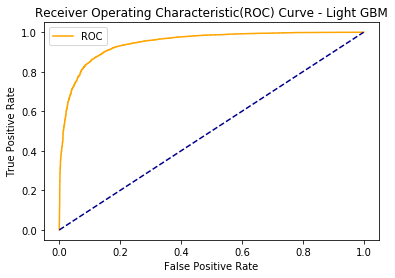

In [70]:
auc = roc_auc_score(y_valid, y_pred)
print('AUC: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(y_valid, y_pred)

plot_roc_curve(fpr, tpr)